### 使用两种神经网络在Fashion-MNIST数据集上进行训练与测试

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader


In [2]:
n_epochs = 300
batch_size_train = 512
batch_size_test = 1024
learning_rate = 0.001
momentum = 0.5
log_interval = 20
random_seed = 1
torch.manual_seed(random_seed)
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
f_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize((0.1307,), (0.3081,))
])
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST('./data/', train=True, download=True,
                                      transform=f_transform),
    batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST('./data/', train=False, download=True,
                                      transform=f_transform),
    batch_size=batch_size_test, shuffle=True)


In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_targets)
print(example_data.shape)


tensor([5, 1, 1,  ..., 2, 7, 3])
torch.Size([1024, 1, 28, 28])


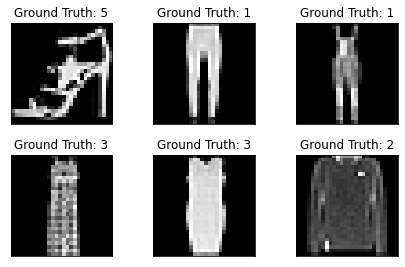

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()


In [18]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class fcNet(nn.Module):

    def __init__(self):
        super(fcNet, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(784, 784),
            nn.LeakyReLU(inplace=True),
            nn.Linear(784, 784),
            nn.LeakyReLU(inplace=True),
            nn.Linear(784, 200),
            nn.LeakyReLU(inplace=True),
            nn.Linear(200, 200),
            nn.LeakyReLU(inplace=True),
            nn.Linear(200, 10),
            nn.Sigmoid(),
            nn.LogSoftmax()
        )

    def forward(self, x):
        x = self.model(x)

        return x


In [19]:
network = fcNet()
network = network.to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)


In [20]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]


In [21]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.view(-1, 28*28)
        output = network(data.to(device))
        loss = F.nll_loss(output, target.to(device))
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')


train(1)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302375
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.302187
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.302535
Train Epoch: 1 [30720/60000 (51%)]	Loss: 2.302273
Train Epoch: 1 [40960/60000 (68%)]	Loss: 2.302221
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.302849


In [22]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(-1, 28*28)
            data = data.to(device)
            target = target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


test()



Test set: Avg. loss: 2.3023, Accuracy: 1000/10000 (10%)



In [23]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()



Test set: Avg. loss: 2.3023, Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302443
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.302309
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.303117
Train Epoch: 1 [30720/60000 (51%)]	Loss: 2.302955
Train Epoch: 1 [40960/60000 (68%)]	Loss: 2.302778
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.302519

Test set: Avg. loss: 2.3022, Accuracy: 1000/10000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.302459
Train Epoch: 2 [10240/60000 (17%)]	Loss: 2.301550
Train Epoch: 2 [20480/60000 (34%)]	Loss: 2.302764
Train Epoch: 2 [30720/60000 (51%)]	Loss: 2.301337
Train Epoch: 2 [40960/60000 (68%)]	Loss: 2.302158
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.301196

Test set: Avg. loss: 2.3021, Accuracy: 1000/10000 (10%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.302141
Train Epoch: 3 [10240/60000 (17%)]	Loss: 2.302018
Train Epoch: 3 [20480/60000 (34%)]	Loss: 2.301729
Train Epoch: 3 [30720/60000 (51%)]	Loss: 2.301831
Train Epoch: 3 [40960/60000 (68%)]	Loss: 